In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import gzip
import shutil
import os

In [249]:
def Read_gz_Binary(file):
    file_tmp = file + "_tmp"
    with gzip.open(file, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    bin_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)
    return bin_data.reshape( [168,128] )

def fill_lack_data(data):
    # まず欠損行の穴埋めは、値が存在する上下端の行の値をそのままコピーする
    data[0:2] = data[2]
    data[154:] = data[153]

    # 欠損列の穴埋めも、値が存在する左右端の列の値をそのままコピーする
    data[:, :8] = data[:, 8].reshape(-1,1)
    return data

# パスのデータの欠損処理
def missing_fix(path):
    data = Read_gz_Binary(path)
    data = fill_lack_data(data)
    
    return data

# 正規化(範囲を 0-255 へ)
def mM_stdize(data):
    tmp = data.reshape(data.shape[0]*data.shape[1], 1)
    m = tmp.min()
    M = tmp.max()
    
    return 255*(data - m)/(M-m)

In [259]:
y='2016'
m='08'
d='20'
h='12'

yn='2016'
mn='08'
dn='20'
hn='13'

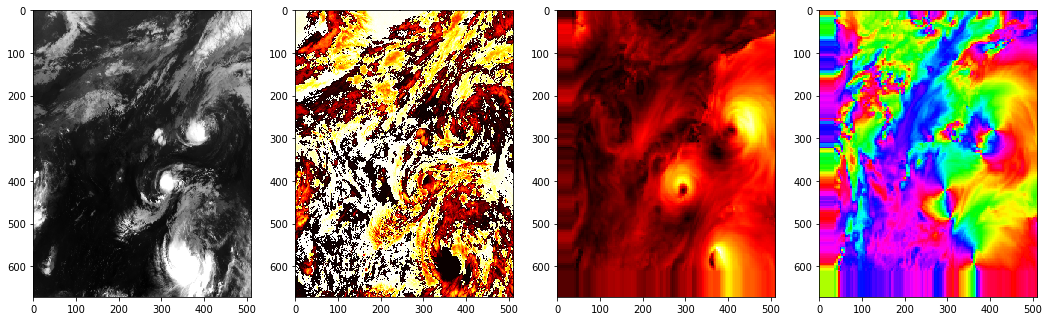

In [267]:
# 雲画像
cloud_data = cv2.imread('../data/input/train/sat/'+y+'-'+m+'-'+d+'/'+y+'-'+m+'-'+d+'-'+h+'-00.fv.png', 0)
next_cloud = cv2.imread('../data/input/train/sat/'+yn+'-'+mn+'-'+dn+'/'+yn+'-'+mn+'-'+dn+'-'+hn+'-00.fv.png', 0)
# 風 ( x 方向)
wx_data = missing_fix('../data/input/train/met/'+y+'/'+m+'/'+d+'/UGRD.850.3.'+y+m+d+h+'.gz').repeat(4,axis=0).repeat(4,axis=1)
# 風 ( y 方向)
wy_data = missing_fix('../data/input/train/met/'+y+'/'+m+'/'+d+'/VGRD.850.3.'+y+m+d+h+'.gz').repeat(4,axis=0).repeat(4,axis=1)
# 風の大きさ
w_norm_data = np.sqrt(wx_data**2 + wy_data**2)
# 風の向き (ラジアン)
w_radian_data = np.arctan(wy_data/wx_data)

plt.figure(figsize=(18,48))
plt.subplot(1,4,1)
plt.imshow(cloud_data, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(cell - next_cell, cmap='hot')
plt.subplot(1,4,3)
plt.imshow(w_norm_data, cmap='hot')
plt.subplot(1,4,4)
plt.imshow(w_radian_data, cmap='hsv')

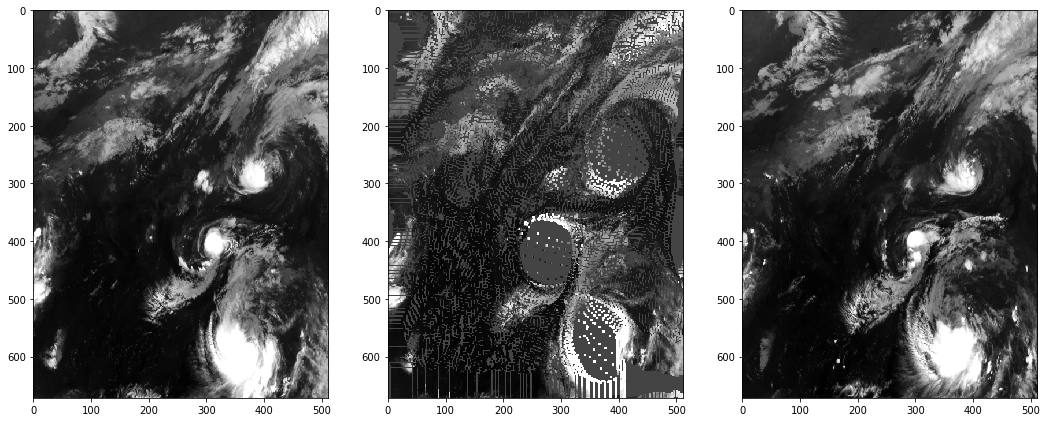

In [268]:
# 風の方向に時刻 t のピクセルを移動

cell = cloud_data
vel_x = wx_data
vel_y = wy_data

next_cell = next_cloud

k = 3
pred_cell = np.ones_like(cell)*cloud_data.mean()
for i in range(cell.shape[0]):
    for j in range(cell.shape[1]):
        try:
            pred_cell[i-int(k*vel_y[i][j])][j+int(k*vel_x[i][j])] = cell[i][j]
        except IndexError:
            pass
plt.figure(figsize=(18,48))
plt.subplot(1,3,1)
plt.imshow(cell, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(pred_cell, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(next_cell, cmap='gray')